In [1]:
# import internal files
from historymatch import emulators
from historymatch import sample
from historymatch import historymatch
from historymatch import plot
from historymatch import utils


# import external modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import pandas as pd
#import importlib
from matplotlib.patches import Rectangle

import sklearn.linear_model as skl

plt.rcParams.update({'font.size': 10})

np.random.seed(4)

In [2]:
# import data

with open("data/MassEval2016.dat",'r') as infile:
    Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11,12),
              names=('N', 'Z', 'A', 'Element', 'Ebinding', 'E_unc'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=64,
              index_col=False)
    
# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
Masses['E_unc'] = pd.to_numeric(Masses['E_unc'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000
Masses['E_unc'] /= 1000

# Group the DataFrame by nucleon number, A.
Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

A0 = Masses['A'].to_numpy()
Z0 = Masses['Z'].to_numpy()
N0 = Masses['N'].to_numpy()
Element = Masses['Element'].to_numpy()
Energies = Masses['Ebinding'].to_numpy()

#Energies_unc = Masses['E_unc'].to_numpy()
Energies_unc = Masses['E_unc'].to_numpy()

In [3]:
def unscale(val, mini, maxi):
        return ((val + 1)*(maxi - mini)*0.5) + mini

In [4]:
# define parameter space

theta_0_bound = np.array([-1, 1]).reshape(1,-1)
theta_1_bound = np.array([-1, 1]).reshape(1,-1)
theta_2_bound = np.array([-1, 1]).reshape(1,-1)

#3D coefficients : [ 7.5645995  -0.03095899  0.19140865]


a0_lim = np.array([7,8.5]).reshape(1,-1)
a1_lim = np.array([-0.05, -0.015]).reshape(1,-1)
a2_lim = np.array([0, 0.4]).reshape(1,-1)

a_limits = np.concatenate((a0_lim, a1_lim, \
                            a2_lim), axis=0)

parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, \
                                   theta_2_bound), axis=0)

theta_0_vals = np.linspace(a_limits[0,0], a_limits[0,1], 100)
theta_1_vals = np.linspace(a_limits[1,0], a_limits[1,1], 100)
theta_2_vals = np.linspace(a_limits[2,0], a_limits[2,1], 100)


theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1)), axis=0)


In [5]:
def LiquidDropModel(a0, a1, a2, A, Z, N):

    
    def unscale(val, mini, maxi):
        return ((val + 1)*(maxi - mini)*0.5) + mini

    a0_lim = np.array([-10,10]).reshape(1,-1)
    a1_lim = np.array([-1, 1]).reshape(1,-1)
    a2_lim = np.array([-1, 3]).reshape(1,-1)

    a_limits = np.concatenate((a0_lim, a1_lim, \
                                a2_lim), axis=0)
    
    return unscale(a0, a_limits[0,0], a_limits[0,1]) + unscale(a1, a_limits[1,0], a_limits[1,1])*A \
                + unscale(a2, a_limits[2,0], a_limits[2,1])*(A**(2.0/3.0))

def LiquidDropModelTrue(a0, a1, a2, A, Z, N):
    
    return a0 + a1*A + a2*(A**(2.0/3.0))


In [6]:
# generate observational data with some uncertainty

start = 20
step = 10
stop = 258

obs_data = Energies[start:stop:step]
sigma_obs = Energies_unc[start:stop:step]
A = A0[start:stop:step]
Z = Z0[start:stop:step]
N = N0[start:stop:step]


variables = np.concatenate((A.reshape(-1,1),Z.reshape(-1,1),\
                            N.reshape(-1,1)), axis=1)

print(obs_data.shape)

(24,)


In [7]:
# Now we set up the design matrix X
X = np.zeros((len(A),3))
X[:,0] = np.ones_like(A)
X[:,1] = A
X[:,2] = A**(2.0/3.0)



In [8]:

clf = skl.LinearRegression(fit_intercept=False).fit(X, obs_data)

print(clf.coef_)

preds = clf.predict(X)


err = np.sum(np.square(obs_data-preds))

pred_sigma = np.sqrt(err / (len(obs_data) - 3 - 1)) 

#https://stats.stackexchange.com/questions/284772/estimator-of-variance-of-error
print(3*pred_sigma)
sigma_model = pred_sigma

print(A[0])
print(Z[0])
print(N[0])


[ 7.88581447 -0.02707252  0.15899617]
0.14604263662644423
30
14
16


In [9]:
print(LiquidDropModelTrue(*clf.coef_, 250, 98, 152))
print(LiquidDropModelTrue( 7.7,-0.0295,0.18, 20, 10, 10))

print(obs_data[0])

7.4274526467679785
8.43625133951054
8.520654


In [10]:
nwaves = 3
ndim = 3
volshape = 'ellipsoid'

In [11]:
#importlib.reload(historymatch)

# initialise history matching class
HM = historymatch.HistoryMatch(ndim, 'GP', volshape)

In [12]:


ToyModel = historymatch.Simulator(HM)
ToyModel.set_simulator(LiquidDropModelTrue)

#obs_data[start:stop:step]

HM.set_observations(obs_data, variables=variables, sigma_obs=sigma_obs, sigma_model=sigma_model)
HM.initialize_volume(a_limits[:,0], a_limits[:,1])

results = HM.run(nwaves=nwaves)

Number of Samples : 200000
(8, 3)
Running wave 1


100%|██████████| 24/24 [00:24<00:00,  1.04s/it]


[23 23 23 ... 23 23 23]
(120, 4)
Convergence : True
Relative nonimplausible volume remaining: 0.201
Running wave 2


100%|██████████| 24/24 [00:24<00:00,  1.00s/it]


[13 13 12 ... 13 23 13]
(140210, 4)
Convergence : True
Relative nonimplausible volume remaining: 0.257
Running wave 3


100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


[12 22  3 ...  0  3  3]
(174259, 4)
Convergence : True
Relative nonimplausible volume remaining: 0.239


In [13]:
plot_wave = 1


In [14]:
#importlib.reload(plot)

#fig, axes = plt.subplots(ndim,ndim,figsize=(10,10))

#plot.plotcorner(results.I_samples[4], parameter_bounds, ndim, bins=20, Fig=(fig,axes), labels=('a0', 'a1', 'a2', 'a3', 'a4', 'a5'))
#axes[1,0].scatter(clf.coef_[0],clf.coef_[1], color='red')
#axes[2,0].scatter(clf.coef_[0],clf.coef_[2], color='red')
#axes[2,1].scatter(clf.coef_[1],clf.coef_[2], color='red')
#axes[3,1].scatter(clf.coef_[1],clf.coef_[3], color='red')
#axes[2,3].scatter(clf.coef_[3],clf.coef_[2], color='red')

#for i in range(ndim):
    #axes[i,i].axvline(clf.coef_[i], color='red')

In [15]:
analytic_mean = np.loadtxt("data/3D_analytic_mean.txt").reshape(ndim,)
analytic_cov = np.loadtxt("data/3D_analytic_cov.txt").reshape(ndim,ndim)

#print(analytic_cov)

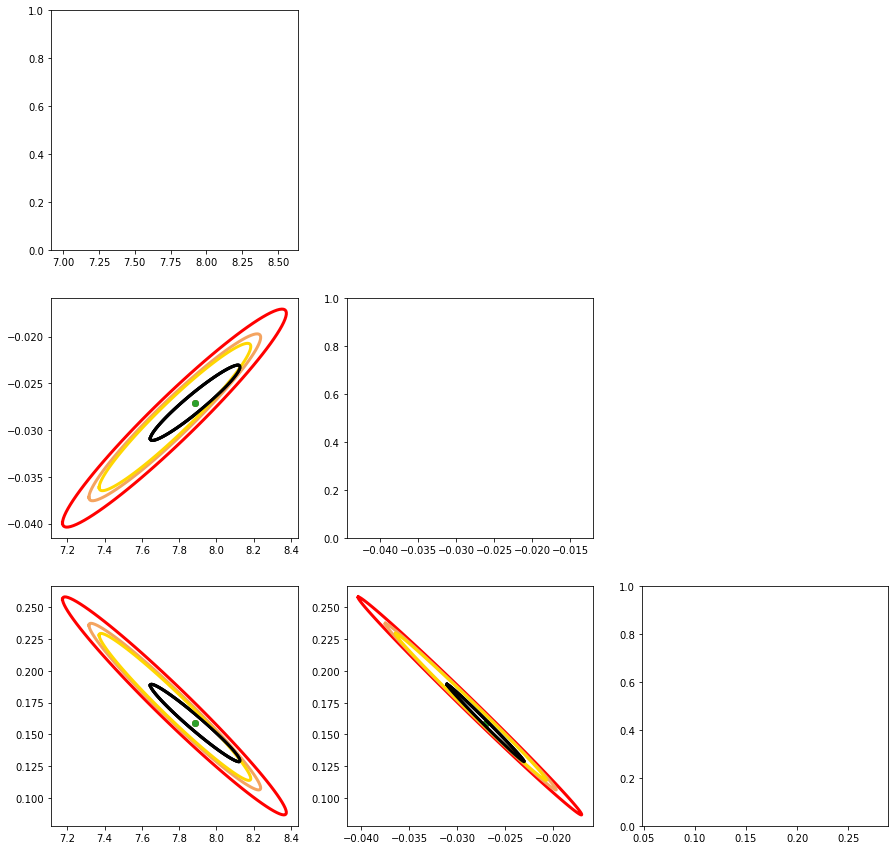

In [16]:
#importlib.reload(plot)

colors = ['red', 'sandybrown', 'gold', 'yellowgreen', 'mediumseagreen', 'turquoise', 'cornflowerblue', 'mediumpurple', 'plum', 'lightpink', ]
theta_names = [r'$a_{0}$', r'$a_{V}$', r'$a_{S}$', r'$a_{C}$', r'$a_{S}$', r'$a_{P}$']

sample_bounds = utils.locate_boundaries(results.samples[-1], ndim)
tempbounds = np.concatenate((sample_bounds[-1].reshape(-1,1),sample_bounds[-1].reshape(-1,1)),axis=1).T

true = clf.coef_
#true = [15.92808016, -18.53454643,  -0.72795844, -23.73239355,]

fig, axes = plt.subplots(ndim, ndim, figsize=(15,15))
if volshape == 'ellipsoid':
    for k in range(nwaves):
        
        nonimplausible_scaled = np.zeros_like(results.nonimplausible[k])
        for dim in range(ndim):
            nonimplausible_scaled[:,dim] = results.nonimplausible[k][:,dim]
        mean = np.mean(nonimplausible_scaled[:,:-1].T, axis=1)
        cov = np.cov(nonimplausible_scaled[:,:-1].T)
        
        test = [7.7,-0.0295,0.18]
        
        for i in range(ndim):
            for j in range(ndim):
                ax = axes[j,i]
                if i < j:
                    true_cov = np.array([[analytic_cov[i,i], analytic_cov[i,j]],[analytic_cov[j,i], analytic_cov[j,j]]])
                    cov_matrix = np.array([[cov[i,i], cov[i,j]],[cov[j,i], cov[j,j]]])
                    plot.get_cov_ellipse(cov_matrix, [mean[i],mean[j]], 3, 5.991, ax, colors[k])
                    plot.get_cov_ellipse(true_cov, [analytic_mean[i],analytic_mean[j]], 3, 5.991, ax, 'black')
                    #ax.set_xlim([parameter_bounds[i][0],parameter_bounds[i][1]])
                    #ax.set_ylim([parameter_bounds[j][0],parameter_bounds[j][1]])
                    ax.scatter(true[i],true[j])
                elif i == j:
                    #ax.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], mean[i], np.sqrt(cov[i,i])), color='plum')
                    ax.set_xlim([sample_bounds[i][0],sample_bounds[i][1]])
                    #ax.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 2)), fontsize=14)
                else:
                    ax.axis('off')
elif volshape == 'hypercube':
    for p in range(nwaves):
        k = -1
        
        nonimplausible_scaled = np.zeros_like(results.nonimp_bounds[k])
        print(results.nonimp_bounds[k].shape)
        for dim in range(ndim):
            nonimplausible_scaled[dim] = unscale(results.nonimp_bounds[k][dim], a_limits[dim,0],  a_limits[dim,1])
            
        for i in range(ndim):
            for j in range(ndim):
                ax = axes[j,i]
                if i < j:
                    #true_cov = np.array([[analytic_cov[i,i], analytic_cov[i,j]],[analytic_cov[j,i], analytic_cov[j,j]]])
                    ax.add_patch(Rectangle((nonimplausible_scaled[i,0], nonimplausible_scaled[j,0]),\
                                           (nonimplausible_scaled[i,1]-nonimplausible_scaled[i,0]), \
                                           (nonimplausible_scaled[j,1]-nonimplausible_scaled[j,0]),\
                        color=colors[k],alpha=0.7,label='Nonimp. Hypercube'))
                    #plot.get_cov_ellipse(true_cov, [analytic_mean[i],analytic_mean[j]], 3, 5.991, ax, 'black')
                    ax.set_xlim([a_limits[i][0],a_limits[i][1]])
                    ax.set_ylim([a_limits[j][0],a_limits[j][1]])
                    ax.scatter(true[i],true[j])
                    ax.set_xlabel(theta_names[i])
                    ax.set_ylabel(theta_names[j])
                else:
                    ax.axis('off')

                    

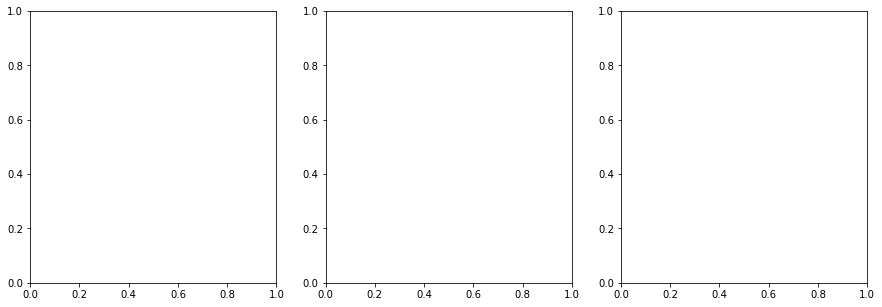

In [17]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

theta_names = [r'$a_{0}$', r'$a_{V}$', r'$a_{S}$', r'$a_{C}$', r'$a_{S}$', r'$a_{P}$']
#col2 = np.where(results.I_samples[1][:,-1]<3,'g','r')
col = 'red'



nonimplausible_scaled = np.zeros_like(results.nonimplausible[0])
samples_scaled = np.zeros_like(results.samples[0])
for dim in range(ndim):
    nonimplausible_scaled[:,dim] = results.nonimplausible[0][:,dim]
    samples_scaled[:,dim] = results.samples[0][:,dim]

    
#for i in np.arange(0,6,2):
    #axes[k].scatter(samples_scaled[:,i], samples_scaled[:,i+1], s=2, color='gold',alpha=0.5, label='Samples')
    #axes[k].scatter(nonimplausible_scaled[:,i], nonimplausible_scaled[:,i+1], s=20, color='red', label='Nonimplausible Samples')
    #axes[k].set_xlabel(theta_names[i])
    #axes[k].set_ylabel(theta_names[i+1])
    #k += 1

#fig.suptitle('Wave 1 Nonimplausible Samples (20,000 Samples)')
#plt.savefig('figures/wave1_pts.png', bbox_inches='tight', facecolor='white', transparent=False)


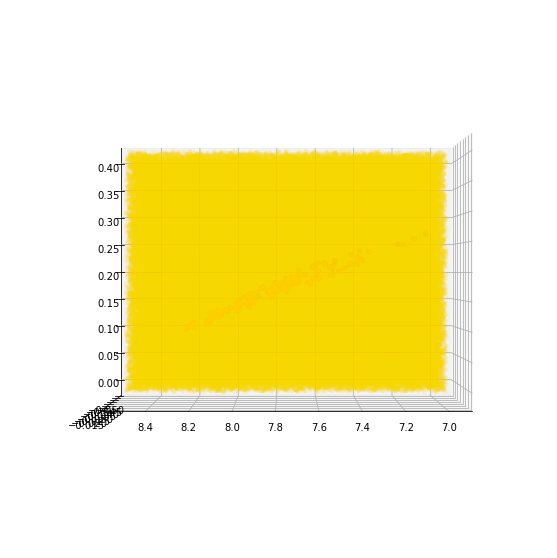

In [18]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter(samples_scaled[:,0], samples_scaled[:,1], samples_scaled[:,2], s=10, color='gold', alpha=0.1, label='Nonimplausible Samples')
ax.scatter(nonimplausible_scaled[:,0], nonimplausible_scaled[:,1], nonimplausible_scaled[:,2], s=20, color='red', label='Nonimplausible Samples')
ax.scatter(true[0],true[1],true[2])
ax.scatter(7.7,-0.0295,0.18)
ax.view_init(0, 90)

In [19]:
'''
fig, axes = plt.subplots(1,ndim,figsize=(40,8))
theta_names = [r'$a_{0}$', r'$a_{V}$', r'$a_{S}$', r'$a_{C}$', r'$a_{S}$', r'$a_{P}$']
#ax1_right = ax1.twinx()

for i in range(ndim):
    
    nonimplausible_scaled = np.zeros_like(results.nonimplausible[-1])
    nonimplausible_scaled[:,i] = unscale(results.nonimplausible[-1][:,i], a_limits[i,0],  a_limits[i,1])
            
    ax_right = axes[i].twinx()
    #plot.opticaldepth_1D(final_wave_HC, parameter_bounds[i], i, bins=50, Fig=(fig, axes[i]), plot_kwargs={'color': 'lightblue'})
    ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], analytic_mean[i],\
                                                np.sqrt(analytic_cov[i,i])), color='orangered', linewidth=3, label='Posterior Distribution')
    axes[i].set(yticklabels=[])  
    axes[i].tick_params(left=False)
    ax_right.set(yticklabels=[])  
    ax_right.tick_params(right=False)
    
    #for j in range(nwaves):
    
    min_a = np.min(nonimplausible_scaled[:,i].T[:-1])
    max_a = np.max(nonimplausible_scaled[:,i].T[:-1])
    axes[i].axvline(min_a, color='grey', linestyle='--', linewidth=3)
    axes[i].axvline(max_a, color='grey', linestyle='--', linewidth=3)
    
    #ax_right.axvline(max_theta1, color='cornflowerblue', linestyle='--', linewidth=3, label=r'Wave 1 Nonimplausible Vol. Limits')
    #ax_right.axvline(max_theta2, color='orange', linestyle='--', linewidth=3)
    #ax_right.axvline(max_theta3, color='grey', linestyle='--', linewidth=3, label=r'Nonimplausible Vol. Limits')
    
    #ax_right.axvline(min_theta1, color='cornflowerblue', linestyle='--', linewidth=3)
    #ax_right.axvline(min_theta2, color='orange', linestyle='--', linewidth=3)
    #ax_right.axvline(min_theta3, color='grey', linestyle='--', linewidth=3)
    
    axes[i].set_ylim([0, None])
    ax_right.set_ylim([0, None])
    #ax_right.set(yticklabels=[])
    
    
    axes[i].set_xlabel(theta_names[i], fontsize=30)
    #ax_right.tick_params(right=False)
    
    #axes[i].set_xticks([-1,-0.5,0,0.5,1]) 
    #axes[i].set_xticklabels([-1.0, -0.5, 0, 0.5, 1.0])
    
    #handles, labels = ax_right.get_legend_handles_labels()
    #patch = mpatches.Patch(color='lightblue', label='Optical Depth')
    #handles.append(patch) 
    #plt.legend(handles=handles, loc='best')
    
    
fig.suptitle('Analytical Likelihood against Wave 3 Nonimplausible Volume (Hypercube)', fontsize=40)
plt.tight_layout()

#plt.savefig('figures/wave3_HC_noem.png', bbox_inches='tight', facecolor='white', transparent=False)'''

"\nfig, axes = plt.subplots(1,ndim,figsize=(40,8))\ntheta_names = [r'$a_{0}$', r'$a_{V}$', r'$a_{S}$', r'$a_{C}$', r'$a_{S}$', r'$a_{P}$']\n#ax1_right = ax1.twinx()\n\nfor i in range(ndim):\n    \n    nonimplausible_scaled = np.zeros_like(results.nonimplausible[-1])\n    nonimplausible_scaled[:,i] = unscale(results.nonimplausible[-1][:,i], a_limits[i,0],  a_limits[i,1])\n            \n    ax_right = axes[i].twinx()\n    #plot.opticaldepth_1D(final_wave_HC, parameter_bounds[i], i, bins=50, Fig=(fig, axes[i]), plot_kwargs={'color': 'lightblue'})\n    ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], analytic_mean[i],                                                np.sqrt(analytic_cov[i,i])), color='orangered', linewidth=3, label='Posterior Distribution')\n    axes[i].set(yticklabels=[])  \n    axes[i].tick_params(left=False)\n    ax_right.set(yticklabels=[])  \n    ax_right.tick_params(right=False)\n    \n    #for j in range(nwaves):\n    \n    min_a = np.min(nonimplausible_scal

In [31]:
dictionary = {'Nsamples : ' : len(results.samples[0]), 'Noutputs : ' : len(obs_data), 'Output First : ' : start, 'Output Last : ' : stop}

keys = np.array(['Nsamples', 'Noutputs', 'StartZ', 'EndZ']).reshape(1,-1)
vals = np.array([len(results.samples[0]), len(obs_data), start, stop]).reshape(1,-1)
    

In [33]:
for wave in range(nwaves):
    file = open("data/{}D_HM_w{}_nonimp.txt".format(ndim,wave), "w")
    np.savetxt(file, results.nonimplausible[wave])
    file.close()
    file3 = open("data/{}D_HM_w{}_samples.txt".format(ndim,wave), "w")
    np.savetxt(file3, results.I_samples[wave])
    file3.close()
    file2 = open("data/{}D_HM_details.txt".format(ndim,wave), "w")
    np.savetxt(file2, keys, fmt="%s")
    np.savetxt(file2, vals, fmt="%d")
    file2.close()